In [1]:

import binascii
%matplotlib inline
from PIL import Image
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import pickle
from scipy import ndimage
import cv2
import skimage.transform as   transform
from skimage.draw import line_aa
import pandas


#im = sk.io.imread(pth)



In [419]:
pth = 'data/resize-3.tif'
#"data/----16019 Parcel U JAMAICA PLAIN, MA (community blders)------Superseded Drawings--Architectural--A1.01-FIRST-FLOOR-PLAN-Rev.0(1).tif"

img = Image.open(pth)
scale = 1
im2 = cv2.imread(pth)
#im2 = transform.rescale(im, scale)

In [2]:
def plot_image(im):
    fig, ax = plt.subplots(figsize=(18, 20))
    ax.imshow(im)


In [39]:
import csv
import re
"""
Import CSV data from OST SQL, and preprocess some data

"""


datapath = 'data/ddatar.csv'
scale_max = 2048
dpi = 216


def unhex (lines):
    for h in range(0, len(lines)):
        binary_string = binascii.unhexlify(lines[h]['Position'][2:])
        x = np.array(binary_string.decode().split(';'))
        y = x.astype(np.float32) 
        scale = scale_max / (int(lines[h]['page_Width']) * dpi)
        s = np.rint(y) * scale * 2.25
        lines[h]['coords'] = s.astype(int)
    return lines

def read_data (pth, uid):
    lines = np.genfromtxt(pth, delimiter="," ,autostrip=True, dtype='str')
    my_dict = []
    for i in range(len(lines)):
        if uid in lines[i][2]:
            row = dict()
            for j in range(len(lines[0])):
                row[lines[0][j]] = lines[i][j]
            my_dict.append(row)      
    return np.array(my_dict)[1:]


def assign_color(lines, cat_label):
    colors = np.random.randint(128, high=255, size=(len(lines), 3)) 
    seen = []
    
    for h in range(0, len(lines)):
        if lines[h][cat_label] not in seen:
            seen.append(lines[h][cat_label])
        
        lines[h]['color'] = colors[seen.index(lines[h][cat_label])]
    return lines
        
def unique_cats(lines, cat_label):
    seen = []
    for h in range(0, len(lines)):
        if lines[h][cat_label] not in seen:
            seen.append( lines[h][cat_label])
    return seen


    
data = read_data(datapath, '111544')       
res = unhex(data)

fnl = assign_color(res, 'catName')
sn = unique_cats(res, 'catName')


['111544']

In [36]:
unique_cats(res, 'pgid')


['000 GSF',
 '08.43 Storefront',
 '08 Louvers',
 '04.10 CMU Masonry',
 '02.85 Fencing',
 '12.93 Site Furnishings',
 '09.65 Resilient Flooring',
 '02.27 Pavement Marking',
 '09.68 Carpeting']

In [31]:
import os

"""


"""
set_path = '16019/out/'
imgs_path = '../../data/sets/';
img_dir = os.listdir(imgs_path + set_path)


def find_image(line, path):
    searches = line['ImagePath'].replace('G:\\Projects\\2016\\Precon', '').replace('tif' , 'jpeg').split('\\')
    s1 = searches[-1:][0]
    s2 = searches[1:][0]
    line['img_loc'] = imgs_path + set_path + [x for x in img_dir if s1 in x.replace(',', '') and s2 in x.replace(',', '')][0]
    return line
    
fnl_msk = find_image(fnl[0], imgs_path)


{'ColorLine': '0',
 'FlipX': '0',
 'FlipY': '0',
 'ImagePath': 'G:\\Projects\\2016\\Precon\\16019 Parcel U JAMAICA PLAIN MA (community blders)\\00 PROJECT DOCUMENTS\\001 MOST CURRENT DWGS\\Architectural\\Converted\\A1.00-BASEMENT-GARAGE-FLOOR-PLAN-Rev.0(1).tif',
 'IsCustomScale': '0',
 'JobName': 'Parcel U Jamaica Plain 4-15-2016 CC',
 'Position': '0x323237362E3839333B313439332E343B323237362E3839333B313639332E3539313B323337342E3839333B313639332E3539313B323337342E3839333B313732312E3537343B323438382E3839333B313732312E3537343B323438382E3839333B313530382E3537343B323435392E3839333B313530382E3537343B323435392E3839333B313439332E340A',
 'Quantity': '0',
 'Quantity1': '11',
 'Quantity2': '0',
 'Quantity3': '0',
 'ScaleStyle': '1',
 'Shape': '-1',
 'ZoomFac': '0.1657407407',
 'catName': '000 GSF',
 'color': array([233, 169, 247]),
 'coords': array([1156,  758, 1156,  860, 1206,  860, 1206,  874, 1264,  874, 1264,
         766, 1249,  766, 1249,  758]),
 'img_loc': '../../data/sets/16019/out/----

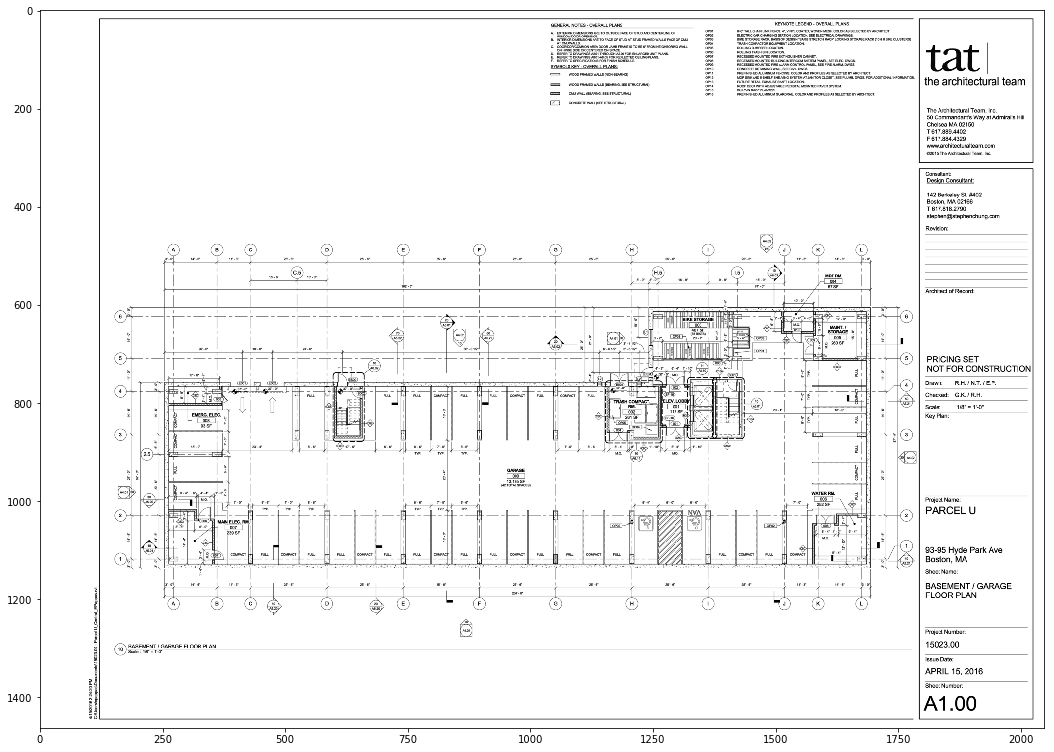

In [32]:
im2pth = fnl_msk['img_loc']
#im2 = Image.open(im2pth)
im2 = cv2.imread(im2pth)
plot_image(im2)
fnl_msk

5.71484375

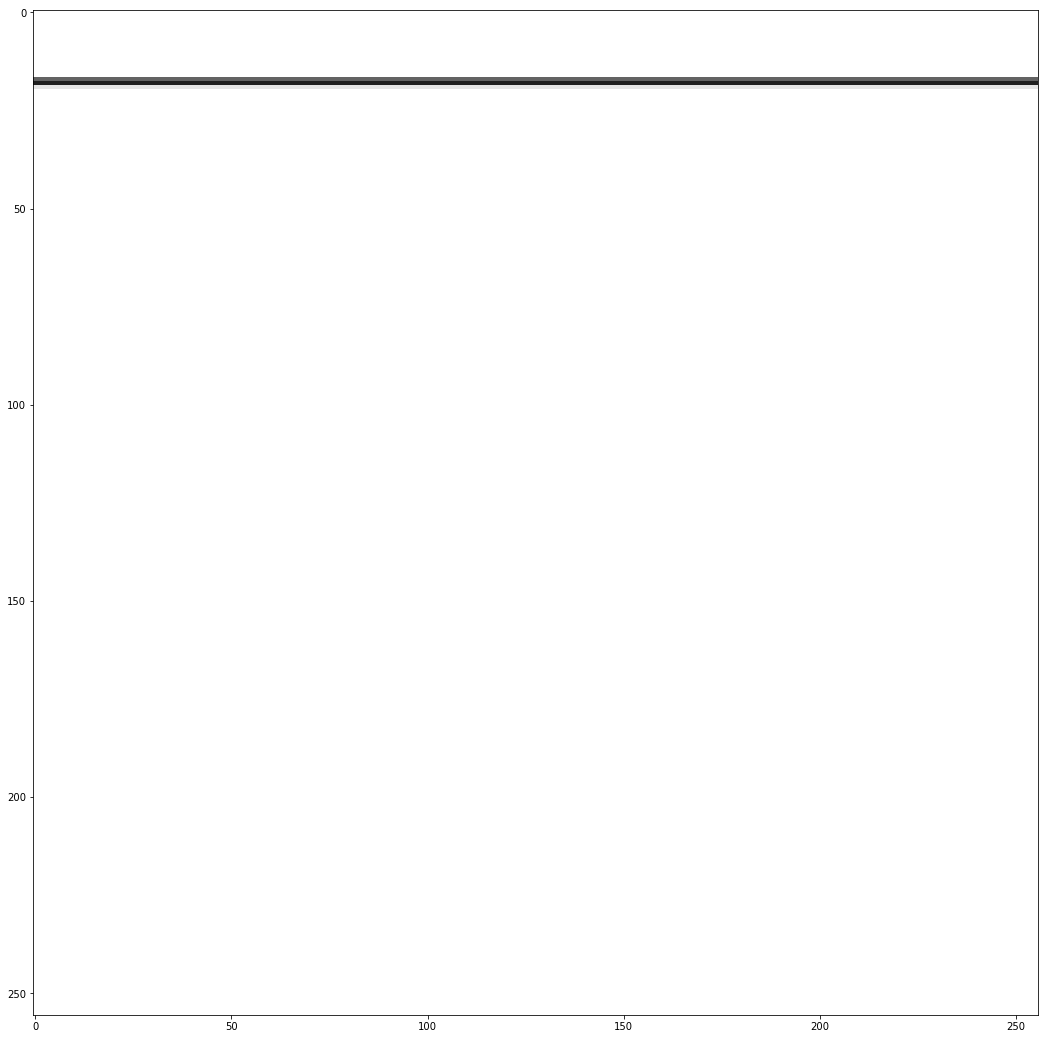

In [44]:
mod_img = im2

def testdraw(image, lines):
    
    for line in lines:
        vec = line['coords']
        if vec.size == 5:
            rr, cc, val = line_aa(vec[1] , vec[0] ,   vec[3] ,  vec[2]  )
            image[rr, cc, 0] = val * line['color'][0]
            image[rr, cc, 1] = val * line['color'][1]
            image[rr, cc, 2] = val * line['color'][2]

    return image

nm = np.zeros(mod_img.shape) 
nm.fill(1)

mod_img = testdraw(mod_img, fnl)

cv2.imwrite("data/test1.jpeg", mod_img)

(def make_img_splits())


plot_image(mod_img[0:256, 256:512])

mod_img.shape[0]/256

In [10]:
#Select 
#bs.JobName, bc.Name, bc.Quantity1, bc.Quantity2, bc.Quantity3, bc.ColorLine,
#pg.Name as pagename, pg.Scale, pg.Width, pg.Height, pg.ScaleFactor1, pg.ScaleFactor2, pg.UID,
#tf.Position,
#bs.BidProjectUID,  tf.Quantity

#--tf1.Position as p1, tf2.Position as p2

#From BidTakeoffs as tf
#Join BidPages as pg On tf.BidPageUID = pg.UID
#--Full Outer Join BidTakeoffs as tf1 On ls.BidTakeoffFromUID = tf1.UID
#--Full Outer Join BidTakeoffs as tf2 On ls.BidTakeoffToUID = tf2.UID
#Join Bids as bs On bs.UID = pg.BidUID
#Left Join BidConditions as bc On tf.BidConditionUID = bc.UID

#--Join BidTypAreas as bt On bc.bid
#Where pg.UID = 82
#10262 aloft San Fran   Lobby Building Perimeter    SFO Aloft SD Dwgs 2010_07_12- PART_1.pdf (3) 

dpi = 216
bit_depth = 1

print(42 * 30 * dpi)
print(42 * dpi)

272160
9072
